In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import holoviews as hv
from holoviews import opts
import hvplot.xarray
import hvplot.networkx as hvnx

from pathlib import Path
from tqdm.notebook import tqdm

import networkx as nx
import geonetworkx as gnx

import warnings

warnings.filterwarnings('ignore')
hv.extension('bokeh')

In [2]:
from reservoirnetwork.network import ReservoirNetwork

%load_ext autoreload
%autoreload 2

In [3]:
# quick and simple implementation without landlab
river_network_pts_fn = Path('../../data-cumberland/cumberland_rivreg_usace/rivreg_pts.geojson')
river_network_fn = Path('../../data-cumberland/cumberland_rivreg_usace/rivreg.geojson')

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
G

{0: Text(-0.4383361282711292, 0.6742317115638135, '0'),
 1: Text(0.21873407567141062, -1.0, '1'),
 2: Text(0.28931630729951124, -0.3873080255134217, '2'),
 3: Text(-0.4792337091251383, -0.09804742665132475, '3'),
 4: Text(0.1709312586681812, 0.23716822240105206, '4'),
 5: Text(-0.22996507221770535, -0.009352442285328293, '5'),
 6: Text(0.48106363033646937, 0.39550657956024515, '6'),
 7: Text(-0.012510362361599461, 0.18780138092496473, '7')}

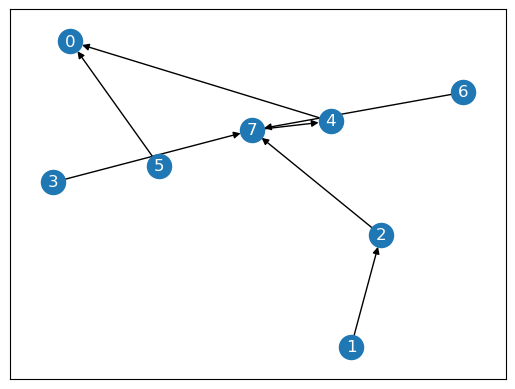

In [4]:
# plot reservoir network

pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [5]:
# aggregate
def aggregate(ds, frequency='weekly'):
    if frequency == 'daily':
        resampled = ds
        resampled['dt'] = ds['time'].resample(time='1D').count()
    elif frequency == 'weekly':
        resampled = ds.resample(time='1W').mean()
        resampled['dt'] = ds['time'].resample(time='1W').count()
    elif frequency == 'monthly':
        resampled = ds.resample(time='1M').mean()
        resampled['dt'] = ds['time'].resample(time='1M').count()
    elif frequency == 'annual':
        resampled = ds.resample(time='1Y').mean()
        resampled['dt'] = ds['time'].resample(time='1Y').count()
    else:
        raise ValueError(f'frequency {frequency} not supported')
    
    return resampled

def calculate_volumes(
        ds, 
        fluxes=['unregulated_inflow', 'obs_inflow', 'obs_outflow', 'obs_storage_change']
    ):
    """Calculate volume values using flow rates and ∆t

    Args:
        ds (xr.Dataset): Dataset containing flow rates in m3/day
    """
    for flux in fluxes:
        ds[flux] = ds[flux] * ds['dt']
        ds[flux].attrs['units'] = 'm3'
        ds[flux].attrs['long_name'] = f'Volume of {flux}'
        ds[flux].attrs['description'] = f'Volume of {flux} in m3'

    return ds

In [122]:
run_type = 'S2'
## sat data - /tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/RAT.2018-2019.regulated.S1.nc
# ds = xr.open_dataset(f'../../data-cumberland/regulation-data/RAT.2018-2019.regulated.{run_type}.nc')
ds = xr.open_dataset(f'../../data-cumberland/regulation-data/RAT.2019-2019.regulated.{run_type}.nc') # newest, with dels from tmsos
# ds = xr.open_dataset(f'/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/insitu.2015-2019.regulated.{run_type}.nc')

# start_time = pd.to_datetime('2015-01-01')
start_time = pd.to_datetime('2019-01-01')
end_time = pd.to_datetime('2019-09-30')

subset = ds.sel(time=slice(start_time, end_time))
aggregated_subset = calculate_volumes(aggregate(subset, 'daily'))

if start_time < aggregated_subset.time.min():
    start_time = aggregated_subset.time.min().values
if end_time > aggregated_subset.time.max():
    end_time = aggregated_subset.time.max().values

forcings = xr.Dataset(
    data_vars={
        'theoretical_natural_runoff': aggregated_subset['unregulated_inflow'],
        # 'storage_change': aggregated_subset['obs_storage_change'],  # use obs_storage change. 
        'storage_change': aggregated_subset['storage_change'] * 1e8, # km3 -> m3
        'obs_inflow': aggregated_subset['obs_inflow'],
        'obs_outflow': aggregated_subset['obs_outflow'],
        'dt': aggregated_subset['dt']
    }
).sel(time=slice(start_time, end_time))

# # TEMP
# forcings = forcings.sel(time=slice('2018-01-01', '2019-09-30'))

forcings

<xarray.Dataset> Size: 74kB
Dimensions:                     (time: 273, node: 8)
Coordinates:
  * time                        (time) datetime64[ns] 2kB 2019-01-01 ... 2019...
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    theoretical_natural_runoff  (time, node) float64 17kB 2.42e+08 ... 1.111e+06
    storage_change              (time, node) float64 17kB nan nan ... -2.608e+04
    obs_inflow                  (time, node) float64 17kB 2.916e+08 ... 7.098...
    obs_outflow                 (time, node) float64 17kB 2.441e+08 ... 1.125...
    dt                          (time) int64 2kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1

#### is the storage change satellite derived?

In [123]:
forcings.sel(node=3)['storage_change'].hvplot()

:Curve   [time]   (storage_change)

In [124]:
forcings.sel(node=3, time=slice('2018-01-01', '2019-09-30'))['storage_change'].hvplot()

:Curve   [time]   (storage_change)

no. yes(2).

### is the inflow observed or modeled?

In [125]:
forcings.sel(node=3)['theoretical_natural_runoff'].hvplot(label='tnr') * forcings.sel(node=3)['obs_inflow'].hvplot(label='observed')

:Overlay
   .Curve.Tnr      :Curve   [time]   (theoretical_natural_runoff)
   .Curve.Observed :Curve   [time]   (obs_inflow)

In [126]:
reservoir_network = ReservoirNetwork(G, start_time)

# algorithm = 'wb_obs_inflow_upstream'  # options: wb (water balance), wb_obs_inflow_upstream (water balance, obs inflow will be used for upstream nodes)
algorithm = 'wb'  # options: wb (water balance), wb_obs_inflow_upstream (water balance, obs inflow will be used for upstream nodes)
print(f"USING {algorithm} ALGORITHM")

for timestep in tqdm(forcings.time.values):
    dt = forcings['dt'].sel(time=timestep).values.item()
    reservoir_network.update(forcings, dt, algorithm)

reservoir_network.data

USING wb ALGORITHM


  0%|          | 0/273 [00:00<?, ?it/s]

<xarray.Dataset> Size: 179kB
Dimensions:                     (node: 8, time: 273)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 2kB 2019-01-01 ... 2019...
Data variables:
    inflow                      (node, time) float64 17kB 4.534e+07 ... 9.656...
    outflow                     (node, time) float64 17kB 0.0 0.0 ... 9.682e+06
    regulated_runoff            (node, time) float64 17kB 7.814e+05 ... 9.679...
    natural_runoff              (node, time) float64 17kB 4.456e+07 ... -2.33...
    theoretical_natural_runoff  (time, node) float64 17kB 2.42e+08 ... 1.111e+06
    storage                     (node, time) float64 17kB nan nan ... nan nan
    storage_change              (time, node) float64 17kB nan nan ... -2.608e+04
    regulation                  (node, time) float64 17kB 1.966e+08 ... -8.54...
    obs_inflow                  (time, node) float64 17kB 2.916e+08 ... 7.098...
    obs_outflow                 (time, node) float64 17kB 2.441e+08 ... 1.125...
    dt                          (time) int64 2kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1

`reservoir_network.data` contains the model results. Plotting and analysis below.

In [127]:
# ds = reservoir_network.data.sel(time=slice('2018-01-01', '2019-09-30'))
ds = reservoir_network.data

In [128]:
NODE = 3
ds.sel(node=NODE).hvplot('time', 'obs_inflow', label='observed inflow') \
* ds.sel(node=NODE).hvplot('time', 'inflow', label='modeled inflow') \
* ds.sel(node=NODE).hvplot('time', 'outflow', label='outflow') \
* ds.sel(node=NODE).hvplot('time', 'theoretical_natural_runoff', label='tnr') \
* ds.sel(node=NODE).hvplot('time', 'storage_change', label='storage change')

:Overlay
   .Curve.Observed_inflow :Curve   [time]   (obs_inflow)
   .Curve.Modeled_inflow  :Curve   [time]   (inflow)
   .Curve.Outflow         :Curve   [time]   (outflow)
   .Curve.Tnr             :Curve   [time]   (theoretical_natural_runoff)
   .Curve.Storage_change  :Curve   [time]   (storage_change)

In [129]:
# reservoir_network.data.to_netcdf(f'/tiger1/pdas47/ResORR-revision/data-cumberland/results/RAT.2018-2019.regulated.{run_type}.nc')

In [130]:
node = 0

ds = reservoir_network.data.sel(time=slice('2018-01-01', '2019-09-30'))
ds['obs_inflow'] = subset['obs_inflow']

ds['inflow'].sel(node=node).hvplot(label='inflow') * ds['obs_inflow'].sel(node=node).hvplot(label='observed') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR')

:Overlay
   .Curve.Inflow   :Curve   [time]   (inflow)
   .Curve.Observed :Curve   [time]   (obs_inflow)
   .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)

In [131]:
from bokeh.models.formatters import NumeralTickFormatter

# plot comparing downstream and upstream nodes
# node = 0
current_node_plot = ds['inflow'].sel(node=node).hvplot(label='inflow').opts(color='#069af3') * ds['obs_inflow'].sel(node=node).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR').opts(color='green', line_dash='3 3')
current_node_plot = current_node_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'))

upstreams = list(reservoir_network.predecessors(node))

plots = [current_node_plot]
for upstream in upstreams:
    upstream_plot = ds['inflow'].sel(node=upstream).hvplot(label='inflow').opts(color='#a2cffe') * ds['obs_inflow'].sel(node=upstream).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=upstream).hvplot(label='TNR').opts(color='green', line_dash='dashed')
    upstream_plot *= ds['storage_change'].sel(node=upstream).hvplot(label='storage change').opts(color='gray')
    upstream_plot *= ds['outflow'].sel(node=upstream).hvplot(label='outflow').opts(color='red')
    upstream_plot = upstream_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'), ylabel='inflow [m3]')
    plots.append(upstream_plot)

import panel as pn

hv.Layout(plots).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Curve.Inflow   :Curve   [time]   (inflow)
      .Curve.Observed :Curve   [time]   (obs_inflow)
      .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)
   .Overlay.II  :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)
   .Overlay.III :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)

In [132]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    # print({'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge})

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

In [133]:
node = 7

rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)

river regulation model results


{'pearson-r': 0.7016281957809297,
 'pearson-r p-val': 1.2506872359811811e-41,
 'nse': -0.9161707986947265,
 'nse1': -0.1072255293475548,
 'rmse': 56743996.51129269,
 'norm_rmse': 0.2910510079422251,
 'mae': 34805089.224378176,
 'norm_mae': 0.17852208027431327,
 'kge': 0.06780556445896024}

In [134]:
rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')

print('TNR vs. Obs results')
get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)

TNR vs. Obs results


{'pearson-r': 0.7500158231130996,
 'pearson-r p-val': 2.1797640863970347e-50,
 'nse': -1.021670883965986,
 'nse1': -0.17884266499309875,
 'rmse': 58285166.25601255,
 'norm_rmse': 0.2989559676769789,
 'mae': 37056338.613115065,
 'norm_mae': 0.19006917677800758,
 'kge': -0.031178738657666738}

## Save stats

- Focus on one dam, Cordell Hull dam.
- Although save stats for all dams.

In [135]:
ds

<xarray.Dataset> Size: 179kB
Dimensions:                     (node: 8, time: 273)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 2kB 2019-01-01 ... 2019...
Data variables:
    inflow                      (node, time) float64 17kB 4.534e+07 ... 9.656...
    outflow                     (node, time) float64 17kB 0.0 0.0 ... 9.682e+06
    regulated_runoff            (node, time) float64 17kB 7.814e+05 ... 9.679...
    natural_runoff              (node, time) float64 17kB 4.456e+07 ... -2.33...
    theoretical_natural_runoff  (time, node) float64 17kB 2.42e+08 ... 1.111e+06
    storage                     (node, time) float64 17kB nan nan ... nan nan
    storage_change              (time, node) float64 17kB nan nan ... -2.608e+04
    regulation                  (node, time) float64 17kB 1.966e+08 ... -8.54...
    obs_inflow                  (time, node) float64 17kB 2.916e+08 ... 7.098...
    obs_outflow                 (time, node) float64 17kB 2.441e+08 ... 1.125...
    dt                          (time) int64 2kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1

In [136]:
nodes_with_upstream = [2, 4, 7, 0]
names = ['Wolf Creek Dam', 'Old Hickory Dam', 'Cordell Hull Dam', 'Barkley Dam']


dfs = []
for node, name in zip(nodes_with_upstream, names):
    print(name)
    rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')
    # print('river regulation model results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)
    model_df = pd.DataFrame(s, index=[node])
    model_df['name'] = name
    model_df['model_or_tnr'] = 'model'

    rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')
    # print('TNR vs. Obs results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)
    tnr_df = pd.DataFrame(s, index=[node])
    tnr_df['name'] = name
    tnr_df['model_or_tnr'] = 'tnr'

    dfs.append(pd.concat([model_df, tnr_df]))

df = pd.concat(dfs)
df

Wolf Creek Dam
Old Hickory Dam
Cordell Hull Dam
Barkley Dam


,pearson-r,pearson-r p-val,nse,nse1,rmse,norm_rmse,mae,norm_mae,kge,name,model_or_tnr
2,0.676034,1.120914e-37,0.450364,0.374484,4.344286e+07,0.109214,2.361299e+07,0.059363,0.584081,Wolf Creek Dam,model
2,0.678102,5.560185e-38,0.452909,0.375395,4.334214e+07,0.108961,2.357860e+07,0.059276,0.588857,Wolf Creek Dam,tnr
4,0.713776,8.212423e-44,0.192844,0.222715,6.089927e+07,0.226644,4.224830e+07,0.157232,0.593982,Old Hickory Dam,model
4,0.779155,6.609122e-57,0.296573,0.255627,5.685163e+07,0.211581,4.045942e+07,0.150575,0.596260,Old Hickory Dam,tnr
7,0.701628,1.250687e-41,-0.916171,-0.107226,5.674400e+07,0.291051,3.480509e+07,0.178522,0.067806,Cordell Hull Dam,model
7,0.750016,2.179764e-50,-1.021671,-0.178843,5.828517e+07,0.298956,3.705634e+07,0.190069,-0.031179,Cordell Hull Dam,tnr
0,0.827021,9.573302e-70,0.566814,0.424522,7.213830e+07,0.131258,4.993920e+07,0.090866,0.737686,Barkley Dam,model
0,0.868078,2.103900e-84,0.630094,0.450830,6.666145e+07,0.121293,4.765622e+07,0.086712,0.738779,Barkley Dam,tnr


In [137]:
import altair as alt

In [138]:
ds.sel(node=4)['theoretical_natural_runoff'].hvplot(label='theoretical_natural_runoff') *\
ds.sel(node=4)['obs_inflow'].hvplot(label='obs_inflow') *\
ds.sel(node=4)['inflow'].hvplot(label='inflow')

:Overlay
   .Curve.Theoretical_natural_runoff :Curve   [time]   (theoretical_natural_runoff)
   .Curve.Obs_inflow                 :Curve   [time]   (obs_inflow)
   .Curve.Inflow                     :Curve   [time]   (inflow)

In [139]:
NODE = 4
# data = df.loc[NODE]
data = df
name = df.loc[NODE, 'name'].unique()[0]
df['name (node)'] = df['name'] + ' (' + df.index.astype(str) + ')'

bars = alt.Chart(
    data
).transform_fold(
    ['nse', 'kge', 'pearson-r', 'norm_rmse', 'norm_mae'],
    ['metric', 'value'],
).mark_circle(
    size=100
).encode(
    x=alt.X('value:Q', title='value'),
    # y=alt.Y('name (node):N', title=None).scale(alt.Scale(domain=['Wolf Creek Dam (2)', 'Cordell Hull Dam (7)', 'Old Hickory Dam (4)', 'Barkley Dam (0)'])),
    y=alt.Y('name:N', title=None).scale(alt.Scale(domain=['Wolf Creek Dam', 'Cordell Hull Dam', 'Old Hickory Dam', 'Barkley Dam'])),
    facet=alt.Facet('metric:N', columns=1),
    color=alt.Color('model_or_tnr:N', title='Model or TNR'),
    tooltip=alt.Tooltip(['pearson-r', 'nse', 'norm_rmse', 'norm_mae', 'kge'], format='.2f'),
    # facet=alt.Facet('name (node):N', columns=1)
).properties(
    width=300,
    height=50,
    # title=f'{name}'
).resolve_scale(
    x='independent'
)

bars

alt.Chart(...)

In [140]:
sat = xr.open_dataset('/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/RAT.2018-2019.regulated.S1.nc')
insitu = xr.open_dataset('/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/insitu.2015-2019.regulated.E4.nc').sel(time=sat.time)

In [146]:
from holoviews import opts
NODE = 3

((insitu['obs_storage_change'].sel(node=NODE) * 1e-6).hvplot(label='in-situ ∆S') * \
(sat['storage_change'].sel(node=NODE) * 1e-6).hvplot(label='Satellite (2018-2019, S1 + L8)') * \
(ds['storage_change'].sel(node=NODE) * 1e-6).hvplot(label='Satellite (2019-onwards, S2 + S1 + L8)')).opts(
    ylabel = '∆S (Million m3)', frame_height=500, frame_width=500, title='Storage change at Dale Hollow Dam'
)

:Overlay
   .Curve.In_hyphen_minus_situ_increment_S                                                                :Curve   [time]   (obs_storage_change)
   .Curve.Satellite_left_parenthesis_2018_hyphen_minus_2019_comma_S1_plus_L8_right_parenthesis            :Curve   [time]   (storage_change)
   .Curve.Satellite_left_parenthesis_2019_hyphen_minus_onwards_comma_S2_plus_S1_plus_L8_right_parenthesis :Curve   [time]   (storage_change)

In [152]:
(xr.open_dataset('/tiger1/pdas47/ResORR/regulation-experiments-calibrated-vic/regulation-data/resorr_forcings.nc')['storage_change'].sel(node=4)*1e9*1e-6).hvplot()

:Curve   [time]   (storage_change)